In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

In [9]:
# connexion a la base de donnees
conn = sqlite3.connect('../Datas/db/fraude_detection_warehouse_.db')

In [10]:
# Extraction des tables
alerts = pd.read_sql_query("SELECT * FROM alerts", conn)
customers = pd.read_sql_query("SELECT * FROM customers", conn)
devices = pd.read_sql_query("SELECT * FROM devices", conn)
transaction_history = pd.read_sql_query("SELECT * FROM transaction_history", conn)
transaction_patterns = pd.read_sql_query("SELECT * FROM transaction_patterns", conn)
transactions = pd.read_sql_query("SELECT * FROM transactions", conn)

alerts.head()


,alert_id,transaction_id,alert_date,alert_type,alert_status,description
0,51a83841-582a-49f0-b1b7-534b593f02d8,19a371c6131c4fadaaa4b59555d41927,2022-04-25 03:40:24,large transaction,closed,Woman life might health ever statement range.\...
1,3eb26fef-a1cf-49e2-ba05-23c0c72a4f7f,5462c26c89794e108f33acd5a6aba434,2020-05-08 18:50:52,large transaction,open,Both his benefit especially development wester...
2,b9103754-365e-42c6-a263-3cd296504dcd,8ad7f3906e4d410988894e9983e21cad,2021-09-10 03:36:03,large transaction,closed,Structure night election civil old. White boy ...
3,5df28a26-9f75-40bc-82a2-a2a43da4f3b8,b9504927c22846babb4943e2597f11c9,2022-04-02 08:03:32,suspicious activity,closed,White big create light blood commercial countr...
4,acc68d65-0fea-4541-a7aa-e0982fdfd4fe,1fc48491d2724c8fb2c3d7ab08c339c8,2024-02-22 10:38:47,large transaction,open,Look her cost. Later which black computer.\nLi...


In [11]:
# Fusion des tables
df1 = transactions.merge(customers, on='customer_id', how='left').drop(columns=['first_name', 'last_name'])
df2 = df1.merge(devices, on='device_id', how='left')
df3 = df2.merge(transaction_history, on=['customer_id', 'transaction_id'], how='left')

df3.head()

,transaction_id,customer_id,device_id,transaction_date_x,transaction_type,amount,status,is_fraud,location,email,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date_y
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,2020-02-12,depôt,9.385805e+06,réussie,1,Douala,Kim.Nguyen@lopez-wolfe.com,...,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1e9c3c0fc0b1496d8d2901d0f8f3531d,1.933918e+07,2.872498e+07,2020-02-12
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,2022-02-03,depôt,3.358191e+06,réussie,0,Bafoussam,Gregory.Webb@scott.com,...,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,d9970217233245029374bceecdc315c0,9.557160e+06,1.291535e+07,2022-02-03
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,2019-11-09,depôt,7.307758e+06,réussie,1,Bafoussam,Mary.Frank@mcbride-oliver.biz,...,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,76fcc12cfc944467b6465cd0aba2893c,1.430163e+07,2.160939e+07,2019-11-09
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,2018-07-18,transfert,3.127519e+06,réussie,1,Bafoussam,Mark.Nelson@yang.info,...,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,3bb9c05095104929b845b85e2daa86e8,7.646344e+06,4.518825e+06,2018-07-18
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,2019-12-29,retrait,4.435274e+06,réussie,0,Yaoundé,Deborah.Stokes@faulkner-randall.net,...,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,64f19595555c42c5ae3d1fb9eb17c793,9.679731e+06,5.244457e+06,2019-12-29


In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      100000 non-null  object 
 1   customer_id         100000 non-null  object 
 2   device_id           100000 non-null  object 
 3   transaction_date_x  100000 non-null  object 
 4   transaction_type    100000 non-null  object 
 5   amount              100000 non-null  float64
 6   status              100000 non-null  object 
 7   is_fraud            100000 non-null  int64  
 8   location            100000 non-null  object 
 9   email               100000 non-null  object 
 10  phone_number        100000 non-null  object 
 11  registration_date   100000 non-null  object 
 12  date_of_birth       100000 non-null  object 
 13  address             100000 non-null  object 
 14  city                100000 non-null  object 
 15  region              100000 non-null

In [13]:
list(df3.columns)

['transaction_id',
 'customer_id',
 'device_id',
 'transaction_date_x',
 'transaction_type',
 'amount',
 'status',
 'is_fraud',
 'location',
 'email',
 'phone_number',
 'registration_date',
 'date_of_birth',
 'address',
 'city',
 'region',
 'device_type',
 'os',
 'manufacturer',
 'model',
 'last_used',
 'history_id',
 'previous_balance',
 'new_balance',
 'transaction_date_y']

In [7]:
date_columns = ["registration_date", "date_of_birth", "transaction_date", "last_used"]

for column in date_columns:
    df3[column] = pd.to_datetime(df3[column])

df3.info()

KeyError: 'transaction_date'

In [ ]:
df3.describe()

In [ ]:
data = df3.copy()
data.drop(columns=["transaction_id", "customer_id", "device_id", "email", "phone_number", "address", "history_id"], inplace=True)
data.head()

In [85]:
# Encodage des variables categorielles
le = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = le.fit_transform(data[col].astype(str))

In [86]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      100000 non-null  int32  
 1   customer_id         100000 non-null  int32  
 2   device_id           100000 non-null  int32  
 3   transaction_date_x  100000 non-null  int32  
 4   transaction_type    100000 non-null  int32  
 5   amount              100000 non-null  float64
 6   status              100000 non-null  int32  
 7   is_fraud            100000 non-null  int64  
 8   location            100000 non-null  int32  
 9   email               100000 non-null  int32  
 10  phone_number        100000 non-null  int32  
 11  registration_date   100000 non-null  int32  
 12  date_of_birth       100000 non-null  int32  
 13  address             100000 non-null  int32  
 14  city                100000 non-null  int32  
 15  region              100000 non-null

In [87]:
df3.describe()

,transaction_id,customer_id,device_id,transaction_date_x,transaction_type,amount,status,is_fraud,location,email,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date_y
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,49999.500000,4997.011860,31643.889520,1094.728150,0.750080,5.587385e+06,0.100280,0.567070,44.62189,5003.649140,...,11.410060,0.502170,1.994680,2.507990,11.042960,31561.620300,49999.500000,1.057399e+07,1.057244e+07,1094.728150
std,28867.657797,2891.162648,18264.383083,632.196196,0.829811,3.514901e+06,0.300374,0.495484,30.26825,2893.387413,...,4.824129,0.499998,1.409231,1.706472,6.654639,18256.170686,28867.657797,4.556663e+06,8.011172e+06,632.196196
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.639254e+02,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.688654e+04,9.024776e+00,0.000000
25%,24999.750000,2496.000000,15760.750000,548.000000,0.000000,2.660834e+06,0.000000,0.000000,16.00000,2485.000000,...,7.000000,0.000000,1.000000,1.000000,5.000000,15724.750000,24999.750000,7.279777e+06,4.493306e+06,548.000000
50%,49999.500000,4988.000000,31739.500000,1095.000000,0.000000,5.309755e+06,0.000000,1.000000,37.00000,5008.000000,...,13.000000,1.000000,2.000000,3.000000,11.000000,31561.500000,49999.500000,1.042128e+07,8.351001e+06,1095.000000
75%,74999.250000,7499.000000,47447.000000,1642.000000,2.000000,8.046252e+06,0.000000,1.000000,74.00000,7511.000000,...,14.000000,1.000000,3.000000,4.000000,17.000000,47342.250000,74999.250000,1.371817e+07,1.563911e+07,1642.000000
max,99999.000000,9999.000000,63258.000000,2191.000000,2.000000,1.574056e+07,1.000000,1.000000,101.00000,9998.000000,...,21.000000,1.000000,4.000000,5.000000,22.000000,63245.000000,99999.000000,2.505568e+07,4.037580e+07,2191.000000


In [88]:
import pandas as pd

# Fonction pour extraire les composantes de date
def extract_date_features(df3, column):
    df3[f'{column}_day'] = df3[column].dt.day
    df3[f'{column}_month'] = df3[column].dt.month
    df3[f'{column}_year'] = df3[column].dt.year
    df3[f'{column}_weekday'] = df3[column].dt.weekday
    return df3

# Conversion des dates et extraction des caractéristiques
date_columns = ['transaction_date_x', 'registration_date', 'date_of_birth']
for col in date_columns:
    df3[col] = pd.to_datetime(df3[col])
    df3 = extract_date_features(df3, col)
    
    # Suppression de la colonne de date originale
    df3 = df3.drop(columns=[col])

# Affichage des nouvelles colonnes pour vérification
print(df3.columns)

Index(['transaction_id', 'customer_id', 'device_id', 'transaction_type',
       'amount', 'status', 'is_fraud', 'location', 'email', 'phone_number',
       'address', 'city', 'region', 'device_type', 'os', 'manufacturer',
       'model', 'last_used', 'history_id', 'previous_balance', 'new_balance',
       'transaction_date_y', 'transaction_date_x_day',
       'transaction_date_x_month', 'transaction_date_x_year',
       'transaction_date_x_weekday', 'registration_date_day',
       'registration_date_month', 'registration_date_year',
       'registration_date_weekday', 'date_of_birth_day', 'date_of_birth_month',
       'date_of_birth_year', 'date_of_birth_weekday'],
      dtype='object')


In [89]:
# Sélectionner uniquement les colonnes de date nouvellement créées
date_columns = [col for col in df3.columns if any(x in col for x in ['_day', '_month', '_year', '_weekday', '_quarter'])]

# Afficher les premières lignes de ces colonnes
print(df3[date_columns].head(10))

   transaction_date_x_day  transaction_date_x_month  transaction_date_x_year  \
0                       1                         1                     1970   
1                       1                         1                     1970   
2                       1                         1                     1970   
3                       1                         1                     1970   
4                       1                         1                     1970   
5                       1                         1                     1970   
6                       1                         1                     1970   
7                       1                         1                     1970   
8                       1                         1                     1970   
9                       1                         1                     1970   

   transaction_date_x_weekday  registration_date_day  registration_date_month  \
0                           3         

In [90]:
print(df3[date_columns].tail(10))

       transaction_date_x_day  transaction_date_x_month  \
99990                       1                         1   
99991                       1                         1   
99992                       1                         1   
99993                       1                         1   
99994                       1                         1   
99995                       1                         1   
99996                       1                         1   
99997                       1                         1   
99998                       1                         1   
99999                       1                         1   

       transaction_date_x_year  transaction_date_x_weekday  \
99990                     1970                           3   
99991                     1970                           3   
99992                     1970                           3   
99993                     1970                           3   
99994                     1970          

In [91]:
# Afficher un résumé statistique de ces colonnes
print(df3[date_columns].describe())

       transaction_date_x_day  transaction_date_x_month  \
count                100000.0                  100000.0   
mean                      1.0                       1.0   
std                       0.0                       0.0   
min                       1.0                       1.0   
25%                       1.0                       1.0   
50%                       1.0                       1.0   
75%                       1.0                       1.0   
max                       1.0                       1.0   

       transaction_date_x_year  transaction_date_x_weekday  \
count                 100000.0                    100000.0   
mean                    1970.0                         3.0   
std                        0.0                         0.0   
min                     1970.0                         3.0   
25%                     1970.0                         3.0   
50%                     1970.0                         3.0   
75%                     1970.0    

In [92]:
# Afficher les types de données de ces colonnes
print(df3[date_columns].dtypes)

transaction_date_x_day        int32
transaction_date_x_month      int32
transaction_date_x_year       int32
transaction_date_x_weekday    int32
registration_date_day         int32
registration_date_month       int32
registration_date_year        int32
registration_date_weekday     int32
date_of_birth_day             int32
date_of_birth_month           int32
date_of_birth_year            int32
date_of_birth_weekday         int32
dtype: object


In [93]:
# Afficher le nombre de valeurs uniques pour chaque colonne
print(df3[date_columns].nunique())

transaction_date_x_day        1
transaction_date_x_month      1
transaction_date_x_year       1
transaction_date_x_weekday    1
registration_date_day         1
registration_date_month       1
registration_date_year        1
registration_date_weekday     1
date_of_birth_day             1
date_of_birth_month           1
date_of_birth_year            1
date_of_birth_weekday         1
dtype: int64


In [94]:
lignes_avec_manquantes = df3[df3.isnull().any(axis=1)]

nombre_lignes_manquantes = lignes_avec_manquantes.shape[0]

print("Nombre de lignes avec des valeurs manquantes :", nombre_lignes_manquantes)

Nombre de lignes avec des valeurs manquantes : 0


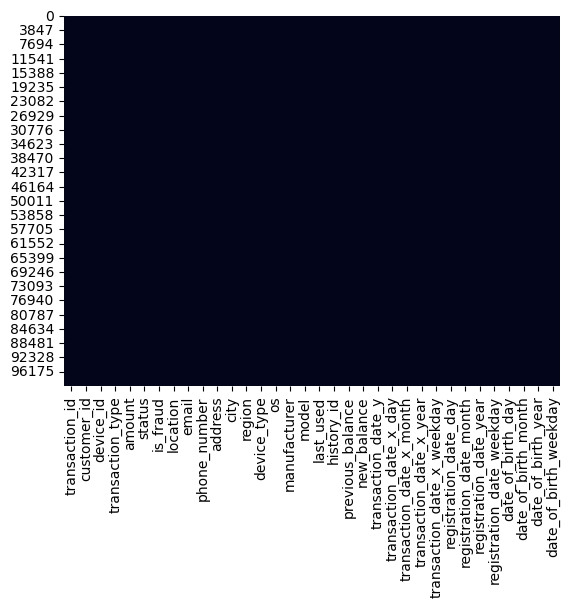

In [95]:
# Visualiser les valeurs manquantes dans un DataFrame 
sns.heatmap(df3.isnull(), cbar=False)
plt.show()

In [96]:
# Gestion des valeurs manquantes
# df3 = df3.fillna(df3.mean())

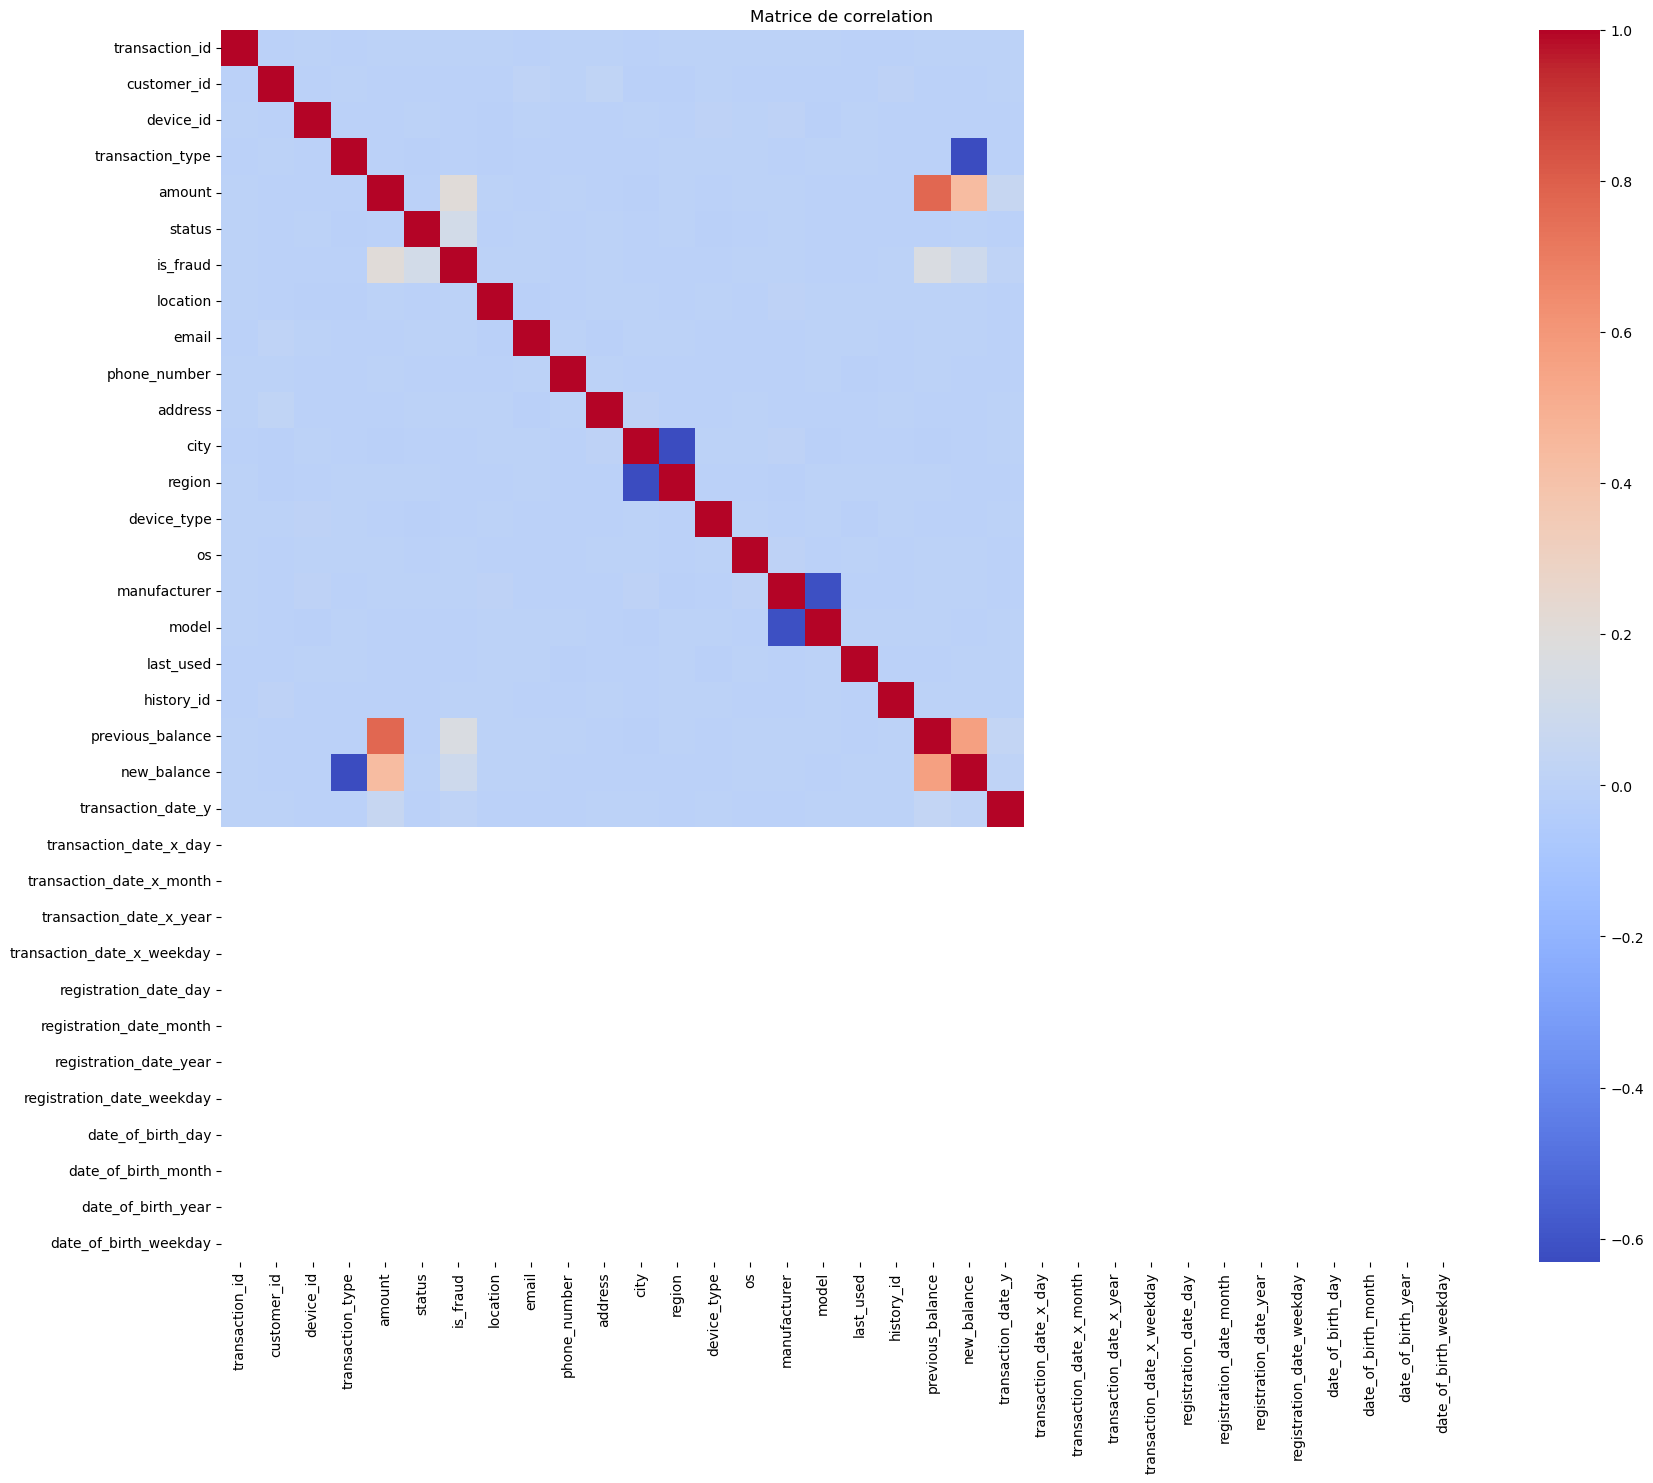

In [97]:
# Analyse de correlation
corr_matrix = df3.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()

In [98]:
# Selection des variables les plus correlees avec is_fraud
correlations_with_fraud = corr_matrix['is_fraud'].abs().sort_values(ascending=False)
print("Top 10 variables les plus corrélées avec is_fraud:")
print(correlations_with_fraud.head(10))

Top 10 variables les plus corrélées avec is_fraud:
is_fraud              1.000000
amount                0.209955
previous_balance      0.162420
status                0.115933
new_balance           0.092639
transaction_date_y    0.016235
location              0.004971
city                  0.004961
model                 0.004522
manufacturer          0.004345
Name: is_fraud, dtype: float64


L'information mutuelle est une mesure statistique qui quantifie la dépendance entre deux variables.

ici, Calcule l'information mutuelle entre chaque variable explicative et la variable cible. 

In [99]:
# Information mutuelle
X = df3.drop(columns=['is_fraud']) #Contient les variables explicatives (indépendantes)
y = df3['is_fraud'] #Contient la variable cible (dépendante)
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print("\nTop 10 variables selon l'information mutuelle:")
print(mi_scores.head(10))


Top 10 variables selon l'information mutuelle:
amount                        0.031331
last_used                     0.016024
device_id                     0.015507
previous_balance              0.013813
new_balance                   0.008821
status                        0.006503
location                      0.004113
date_of_birth_weekday         0.002579
city                          0.002416
transaction_date_x_weekday    0.002206
Name: MI Scores, dtype: float64


In [100]:
# Sélection finale des variables importantes
important_features = list(set(list(correlations_with_fraud.head(10).index) + list(mi_scores.head(10).index)))
important_features = [f for f in important_features if f != 'is_fraud']
print("\nVariables importantes sélectionnées:")
print(important_features)


Variables importantes sélectionnées:
['date_of_birth_weekday', 'status', 'manufacturer', 'new_balance', 'transaction_date_x_weekday', 'previous_balance', 'location', 'device_id', 'last_used', 'amount', 'model', 'city', 'transaction_date_y']


In [101]:
# Creation du dataset final
X_final = df3[important_features] # Cette variable sera utilisée pour stocker les variables explicatives(indépendantes)
y_final = df3['is_fraud']

Isolation Forest: calcule un score d'anomalie pour chaque observation du dataset. Ce score donne une mesure de la normalité de chaque observation en fonction de l'ensemble des données.

In [102]:
# Entrainement du modele avec Isolation Forest
model = IsolationForest(contamination=0.5, random_state=42)
y_pred = model.fit_predict(X_final)

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [103]:
y_pred

array([-1,  1,  1, ..., -1,  1,  1])

La première transaction n'est pas considérée comme frauduleuse (prédiction : -1).

La deuxième transaction est considérée comme frauduleuse (prédiction : 1).

etc

In [104]:
# Ajout des predictions du DataFrame
df3['anomaly'] = y_pred

In [105]:
# Affichage des resultats
print("\nNombre d'anomalies detectees:", sum(y_pred == -1))
print("\nExemples d'anomalies detectees:")
print(df3[df3['anomaly'] == -1].head()) # sélectionne uniquement les lignes du DataFrame df où la condition est True (c'est-à-dire les lignes correspondant aux anomalies).


Nombre d'anomalies detectees: 50000

Exemples d'anomalies detectees:
   transaction_id  customer_id  device_id  transaction_type        amount  \
0           45184         8116      60985                 0  9.385805e+06   
5           27378         1763       8486                 0  8.835403e+06   
6           52653         6622        643                 1  7.034970e+06   
7           85227         4213      49353                 1  4.644982e+06   
8           42197          874      61373                 1  1.129839e+07   

   status  is_fraud  location  email  phone_number  ...  \
0       0         1        31   5665          1606  ...   
5       0         1        16   2906          6715  ...   
6       0         1        98   5180          8974  ...   
7       0         0        31   6979          2674  ...   
8       0         1        39   4129          7097  ...   

   transaction_date_x_weekday  registration_date_day  registration_date_month  \
0                           3  

In [106]:
# evaluons la precision du modele
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Convertir les prédictions de l'Isolation Forest (-1 pour anomalie, 1 pour normal) 
# en format binaire (1 pour anomalie, 0 pour normal)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Calculer et afficher les métriques de classification
print(classification_report(y_final, y_pred_binary))

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_final, y_pred_binary)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       0.49      0.56      0.52     43293
           1       0.62      0.55      0.58     56707

    accuracy                           0.56    100000
   macro avg       0.56      0.56      0.55    100000
weighted avg       0.56      0.56      0.56    100000

AUC-ROC: 0.5562012595900026


Un AUC-ROC de 0.5562 indique que votre modèle de classification a des performances très faibles. Il ne parvient pas à discriminer efficacement les classes positives des négatives.

In [107]:
# Afficher la matrice de confusion
print("Matrice de confusion:")
print(confusion_matrix(y_final, y_pred_binary))

Matrice de confusion:
[[24406 18887]
 [25594 31113]]


In [108]:
# Affichage des résultats
print("\nNombre d'anomalies détectées:", sum(y_pred == -1))
print("\nExemples d'anomalies détectées:")
print(df3[df3['anomaly'] == -1].head())


Nombre d'anomalies détectées: 50000

Exemples d'anomalies détectées:
   transaction_id  customer_id  device_id  transaction_type        amount  \
0           45184         8116      60985                 0  9.385805e+06   
5           27378         1763       8486                 0  8.835403e+06   
6           52653         6622        643                 1  7.034970e+06   
7           85227         4213      49353                 1  4.644982e+06   
8           42197          874      61373                 1  1.129839e+07   

   status  is_fraud  location  email  phone_number  ...  \
0       0         1        31   5665          1606  ...   
5       0         1        16   2906          6715  ...   
6       0         1        98   5180          8974  ...   
7       0         0        31   6979          2674  ...   
8       0         1        39   4129          7097  ...   

   transaction_date_x_weekday  registration_date_day  registration_date_month  \
0                           3  